In [1]:
import numpy as np
import camb
from camb import model, initialpower
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
from scipy.interpolate import interp1d
import pickle

In [2]:
Omega_matter = 0.2814
Hubble_param = 69.7
h = Hubble_param / 100
n_s = 0.9667

Om_bh2 = 0.0240 # Omega_baryons * h**2; From Planck 2018 results
Om_mh2 = 0.1404 # Omega_matter * h**2; From Planck 2018 results
OmB_OmM = Om_bh2 / Om_mh2 # Omega_baryons / Omega_matter

params = {
    'flat': True,
    'H0': Hubble_param,
    'Om0': Omega_matter,
    'Ob0': OmB_OmM * Omega_matter,
    'sigma8': 0.796,
    'ns': n_s
}
cosmo = cosmology.setCosmology('my_cosmo', params)

omega_m_today = cosmo.Om0
Omega_rad_today = cosmo.Ogamma0 + cosmo.Onu0
z_eq = omega_m_today / Omega_rad_today - 1

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest 

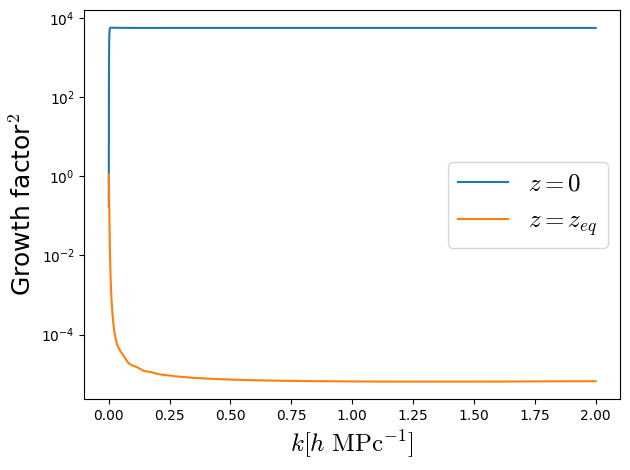

In [3]:
Omega_b_h2 = OmB_OmM * Omega_matter * h**2
Omega_cdm_h2 = (1 - OmB_OmM) * Omega_matter * h**2


# Set up the cosmological parameters
pars = camb.CAMBparams()
pars_norm = camb.CAMBparams()
pars.set_cosmology(H0=Hubble_param, ombh2=Omega_b_h2, omch2=Omega_cdm_h2)
pars_norm.set_cosmology(H0=Hubble_param, ombh2=Omega_b_h2, omch2=Omega_cdm_h2)
pars.InitPower.set_params(ns=n_s)
pars_norm.InitPower.set_params(ns=n_s)

# Set the initial conditions for isocurvature perturbations
pars.scalar_initial_condition = "initial_iso_CDM"
pars_norm.scalar_initial_condition = "initial_iso_CDM"

#The redshift at which we want to normalize the isocurvation growth function - corresponds to X2021 eqn (3)
z_norm = 100

min_kh = 1e-4
max_kh = 2
npoints_kh = 1000
#Compute the power spectrum for z_norm
pars_norm.set_matter_power(redshifts=[z_norm], kmax=max_kh)
results_norm = camb.get_results(pars_norm)
ks_norm, zs_norm, pk_norm = results_norm.get_matter_power_spectrum(minkh=min_kh, maxkh=max_kh, npoints=npoints_kh)
initial_pk = pk_norm[0, :] #power spectrum at z_norm

highest_redshift = z_eq * 70 # the mmaximum redshift you need the growth factor for

num_redshifts_temp = highest_redshift * 10 + 1 # redshift resolution of exactly 0.1. This is only the approximate number of redshift points.
num_redshifts_actual = 256 * int(np.ceil(num_redshifts_temp / 256)) # we round up the number of redshift points such that 'num_redshifts_actual' is exactly divisible by 256. We choose 256 because CAMB can crunch the matter
                                                                    # power spectrum for 256 redshifts in one call of the 'get_matter_power_spectrum(,,)' function.
redshifts = np.linspace( 0 , highest_redshift, num_redshifts_actual ).reshape(int(num_redshifts_actual / 256), 256) # Creates a linearly space array of redshift points and reshapes to a 2D array such that there are 
                                                                            # exactly 256 columns
growth_factors_of_z = np.zeros(num_redshifts_actual) # Initliazing the growth factors array. This will contain the value of the growth function at each value of redshift
redshifts_for_interpolation = np.zeros(num_redshifts_actual)

plt.rcParams["mathtext.fontset"] = "cm"
for i in range(int(num_redshifts_actual / 256)):
    redshifts_CAMB_256 = redshifts[i, :] # Considering the 'i'th row of reshifts. There will be 256 values of redshifts considered.
    pars.set_matter_power(redshifts=redshifts_CAMB_256, kmax=max_kh)

    # Compute the results
    results = camb.get_results(pars)

    # Get the matter power spectrum
    ks, zs, pk = results.get_matter_power_spectrum(minkh=min_kh, maxkh=max_kh, npoints=npoints_kh) # 'ks' is the value of 'k/h'; 'pk' is the value of the power spectrum


    # We plot the power spetrum vs 'k' for the least (0) and highest ('highest_redshift') redshifts just to ensure that the power spectrum has stabilized (become flat) at the highest 'k' values considered.
    # We do not want the growth function to have a 'k' dependence.
    if i == 0: # first iteration
        plt.semilogy(ks, pk[0, :] / initial_pk[:], label=r"$z = 0$")
    elif i == int(num_redshifts_actual / 256) - 1: # last iteration
        plt.semilogy(ks, pk[-1, :] / initial_pk[:], label=r"$z = z_{eq}$")

    # Calculate the growth factor
    growth_factors_squared = pk[:, -1] / initial_pk[-1] # for each redshift, the growth factor squared is calcaulated by dividing the power spectrum value corresponding to the highest value of 'k' at that redshift
                                                        # by the power spectrum value corresponding to the highest value of 'k' at reference redshift 'z_norm'
    growth_factors = np.sqrt(growth_factors_squared)
    
    redshifts_for_interpolation[256*i : 256*(i+1)] = zs # the redsift values considered are stored in a 1D array
    growth_factors_of_z[256*i : 256*(i+1)] = growth_factors # the growth function values for corresponding reshift are stored in a 1D array

plt.legend(fontsize=18)
plt.xlabel(r"$k [h\ \mathrm{MPc}^{-1}]$", fontsize=18)
plt.ylabel(r"Growth factor$^{2}$", fontsize=18)
plt.tight_layout()
# plt.savefig("Growth factor squared as a function of k for z = 0, z_eq.pdf")
plt.show()

growth_factor_of_z_interpolator = interp1d(redshifts_for_interpolation, growth_factors_of_z, kind='linear') # Creates an interpolator object that takes as input the value of redshift and outputs the value of growth function.


In [4]:
# Normalizing the growth factor to match X2021 eqn (3) in the matter-dominated epoch

def get_growth_factor_X2021(z):
    return 2/3 + (1 + z_eq)/(1 + z)

# My way
z_ref = 10 # reference redshift well within the matter dominated epoch
a_10 = 1 / (1 + z_ref) # scale factor corresponding to redshift 'z_ref'
a_eq = 1 / (1 + z_eq) # scale factor at matter-radiation equality
slope_CAMB = ( growth_factor_of_z_interpolator(z_ref) - growth_factor_of_z_interpolator(z_eq) ) / (a_10 - a_eq) # slope of the CAMB growth function between reshifts 'z_eq' and 'z_ref'
growth_factor_normalized = growth_factor_of_z_interpolator(redshifts_for_interpolation) / slope_CAMB / a_eq


growth_factor_normalized_interpolator = interp1d(redshifts_for_interpolation, growth_factor_normalized, kind='linear')

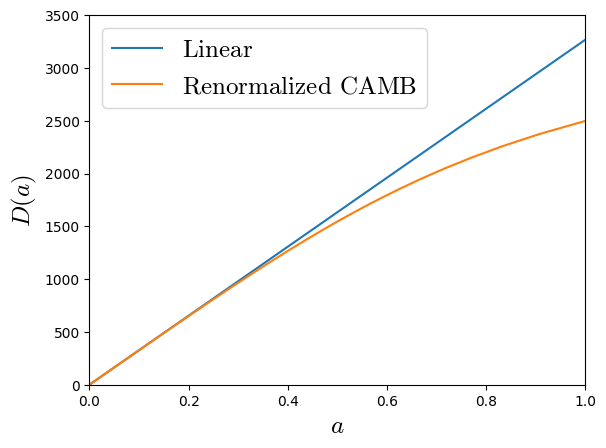

In [5]:
plt.rcParams["mathtext.fontset"] = "cm"

plt.plot(1 / (1 + redshifts_for_interpolation), get_growth_factor_X2021(redshifts_for_interpolation), label=r"$\text{Linear}$")
plt.plot(1 / (1 + redshifts_for_interpolation), growth_factor_normalized, label=r"$\text{Renormalized CAMB}$")
plt.legend(fontsize=18)
plt.xlabel(r"$a$", fontsize=18)
plt.ylabel(r"$D(a)$", fontsize=18)
plt.xlim(0, 1)
plt.ylim(0, 3500)
# plt.savefig("growth_factor_CAMB_vs_linear.pdf")
plt.show()